# General information

Here, the preceding elements represent the following:

- x0, y0: The coordinates of the top left of the bounding box
- x1, y1: The coordinates of the bottom right of the bounding box
- w, h: The width and height of the bounding box
- xc, yc: The coordinates of the centroid of the bounding box

As an example, let's look at the following screenshot in which xc, yc = 1099, 1035; w, h = 500,
500; x0, y0 = 849, 785; and x1, y1 = 1349, 1285:

Therefore, the goal of single-object detection will be to predict a bounding box using four
numbers. In the case of square objects, we can fix the width and height and simplify the
problem to predict just two numbers. In this chapter, we will learn to create an algorithm to
locate the fovea in eye images using two numbers.

The ADAM challenge focuses on the investigation and development of algorithms associated with the diagnosis of Age-related Macular degeneration (AMD) and segmentation of lesions in fundus photos from AMD patients. The goal of the challenge is to evaluate and compare automated algorithms for the detection of AMD on a common dataset of retinal fundus images. We invite the medical image analysis community to participate by developing and testing existing and novel automated fundus classification and segmentation methods

# Data Exploratory

In [71]:
member

<ZipInfo filename='Training400/Non-AMD/N0311.jpg' compress_type=deflate external_attr=0x20 file_size=992402 compress_size=984413>

In [82]:
%%time
import shutil
import zipfile
file_broken=[]
path_to_zip_file='/content/drive/My Drive/Data/Vision/AMD challenge/AMD-Training400.zip'
directory_to_extract_to='/content/data/'
z = zipfile.ZipFile(path_to_zip_file, allowZip64=True)
for member in z.infolist():
  try:
    z.extract(member,path=directory_to_extract_to)
  except:
    print('problem file: ',member.filename)
    file_broken.append(member.filename)
    continue
    # log the error, the member.filename, whatever

shutil.copy("/content/drive/My Drive/Data/Vision/AMD challenge/Fovea_location.xlsx", "/content/data/Training400")

problem file:  Training400/AMD/A0012.jpg
problem file:  Training400/AMD/A0013.jpg
CPU times: user 4.74 s, sys: 1.37 s, total: 6.1 s
Wall time: 7.14 s


1. Let's begin by loading Fovea_location.xlsx and printing out its head:

Then, we loaded the file into a pandas DataFrame and printed out its head. The
DataFrame has three columns: imgName, Fovea_X, and Fovea_Y. The imgName column
refers to the image filename, while Fovea_X and Fovea_Y represent the X and Y
coordinates of the fovea center. Note that the first 89 rows correspond to the AMD images
and start with the letter A.

In [83]:
file_broken

['Training400/AMD/A0012.jpg', 'Training400/AMD/A0013.jpg']

In [96]:
img_list=[]
for file in file_broken:
  img_name=file.split('/')[2]
  img_list.append(img_name)
img_list

['A0012.jpg', 'A0013.jpg']

In [91]:
import os
import pandas as pd

path2data="./data/"

# full path of labels file
path2labels=os.path.join(path2data,"Training400","Fovea_location.xlsx")

# maske sure to install xlrd
labels_df=pd.read_excel(path2labels,index_col="ID")

labels_df.head(20)

,imgName,Fovea_X,Fovea_Y
ID,,,
1,A0001.jpg,1182.264278,1022.018842
2,A0002.jpg,967.754046,1016.946655
3,A0003.jpg,1220.206714,989.944033
4,A0004.jpg,1141.140888,1000.594955
5,A0005.jpg,1127.371832,1071.109440
6,A0006.jpg,1118.941434,1012.658813
7,A0007.jpg,1254.419128,1159.823156
8,A0008.jpg,701.298985,778.826745
9,A0009.jpg,1122.130378,1204.887661


In [101]:
#Filter image broken
labels_df=labels_df[~labels_df.imgName.isin(img_list)]

In [102]:
path2labels

'./data/Training400/Fovea_location.xlsx'

In step 2, we printed out the tail of the DataFrame. You can see that ID reaches 400, the
same as the number of images. Also, note that the last 311 rows correspond to the Non-AMD
images and start with the letter N.

In [103]:
labels_df.tail()

,imgName,Fovea_X,Fovea_Y
ID,,,
396,N0307.jpg,823.024991,690.210211
397,N0308.jpg,647.598978,795.653188
398,N0309.jpg,624.571803,755.694880
399,N0310.jpg,687.523044,830.449187
400,N0311.jpg,746.107631,759.623062


In step 3, we showed the scatterplot of Fovea_X and Fovea_Y. We used the seaborn library
to show the scatterplot. Seaborn is a Python data visualization library based on
matplotlib. It provides a high-level interface for drawing attractive and informative
statistical graphics.

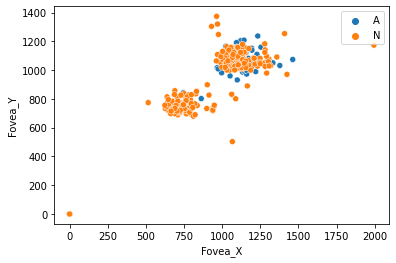

In [104]:
# make sure seaborn is installed!
import seaborn as sns
%matplotlib inline

AorN=[imn[0] for imn in labels_df.imgName]
sns.scatterplot(x=labels_df['Fovea_X'], y=labels_df['Fovea_Y'],hue=AorN)

4. Next, we will show a few sample images. We will import the required packages
and fix the random seed:

In step 4, we displayed a few random images with the fovea bounding boxes. The fovea
location is given as a center point. Therefore, to show a bounding box, we create a rectangle
using rectangle from the PIL.imageDraw package at the center of the fovea. We also
printed the image sizes. As we saw, images have different sizes.

In [105]:
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pylab as plt

# fix random seed
np.random.seed(2019)

In [106]:
plt.rcParams['figure.figsize'] = (15, 9)
plt.subplots_adjust(wspace=0, hspace=0.3)
nrows,ncols=2,3

<Figure size 1080x648 with 0 Axes>

Then, we will select a random set of image id

In [107]:
# get imgName column
imgName=labels_df["imgName"]

# get ids
ids=labels_df.index

# select random ids
rndIds=np.random.choice(ids,nrows*ncols)
print(rndIds)

[ 75 373 162 296 219 193]


Next, we will define a helper function to load an image and its label from the local
files:

In [108]:
# Dua vao ten du lieu trong labels_df tim image trong data trung voi ten do
def load_img_label(labels_df,id_):    
    imgName=labels_df["imgName"]    
    if imgName[id_][0]=="A":
        prefix="AMD"
    else:
        prefix="Non-AMD"
            
    fullPath2img=os.path.join(path2data,"Training400",prefix,imgName[id_])
    # filename='Training400/AMD/A0012.jpg'
    img = Image.open(fullPath2img)
    
    # centroid
    x=labels_df["Fovea_X"][id_]
    y=labels_df["Fovea_Y"][id_]
    
    label=(x,y)
    return img,label

Next, we will define a helper function to show the image and label as a bounding
box:

In [109]:
def show_img_label(img,label,w_h=(50,50),thickness=2):   
    w,h=w_h                   
    cx,cy=label
    
    # draw a rectangle 
    draw = ImageDraw.Draw(img)
    draw.rectangle(((cx-w/2, cy-h/2), (cx+w/2, cy+h/2)),outline="green",width=thickness)

    plt.imshow(np.asarray(img))

Then, we will show the selected images together with the fovea bounding boxes:

(2124, 2056) (1172.97048128342, 1082.46385026738)
(1444, 1444) (802.729556611839, 734.550832458648)
(1444, 1444) (762.541537279049, 808.185683889582)
(2124, 2056) (1231.98866983552, 1027.92523301505)
(2124, 2056) (1019.93326509295, 1044.24177285545)
(2124, 2056) (1108.25889969404, 1040.93232020263)


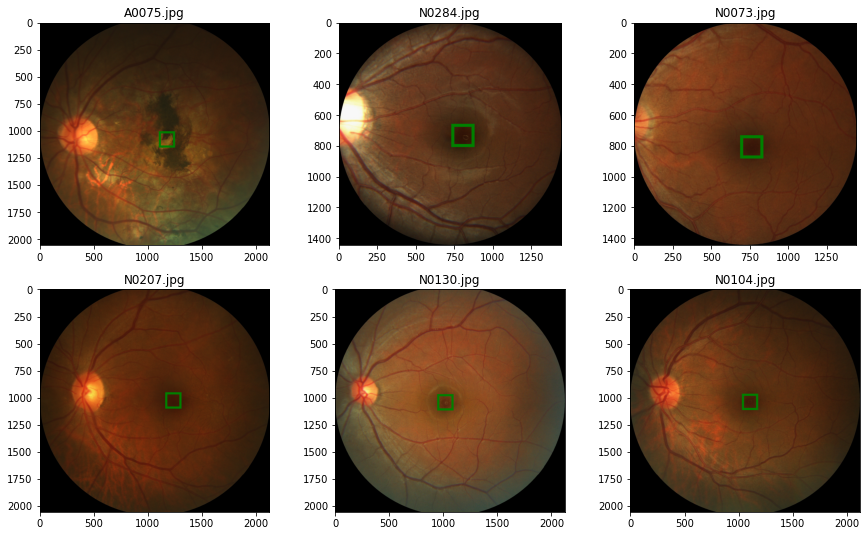

In [110]:
for i,id_ in enumerate(rndIds):
    
    img,label=load_img_label(labels_df,id_)   
    print(img.size,label)
    
    plt.subplot(nrows, ncols, i+1) 
    show_img_label(img,label,w_h=(150,150),thickness=20)
    plt.title(imgName[id_])

Luu y: chi co du lieu center diem vang, o vuong xanh la do tu ve

5. Next, we will collect the image widths and heights in two lists:

In [111]:
imgName

ID
1      A0001.jpg
2      A0002.jpg
3      A0003.jpg
4      A0004.jpg
5      A0005.jpg
         ...    
396    N0307.jpg
397    N0308.jpg
398    N0309.jpg
399    N0310.jpg
400    N0311.jpg
Name: imgName, Length: 398, dtype: object

In [112]:
h_list,w_list=[],[]
for id_ in ids:
    if imgName[id_][0]=="A":
        prefix="AMD"
    else:
        prefix="Non-AMD"
        
    fullPath2img=os.path.join(path2data,"Training400",prefix,imgName[id_])
        
    # load image
    img = Image.open(fullPath2img)
    h,w=img.size
    h_list.append(h)
    w_list.append(w)

6. Then, we will plot the distributions of heights and widths:

In [113]:
print(h_list[:20])

[2124, 2124, 2124, 2124, 2124, 2124, 2124, 1444, 2124, 2124, 2124, 2124, 2124, 2124, 2124, 2124, 2124, 1444, 2124, 2124]


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


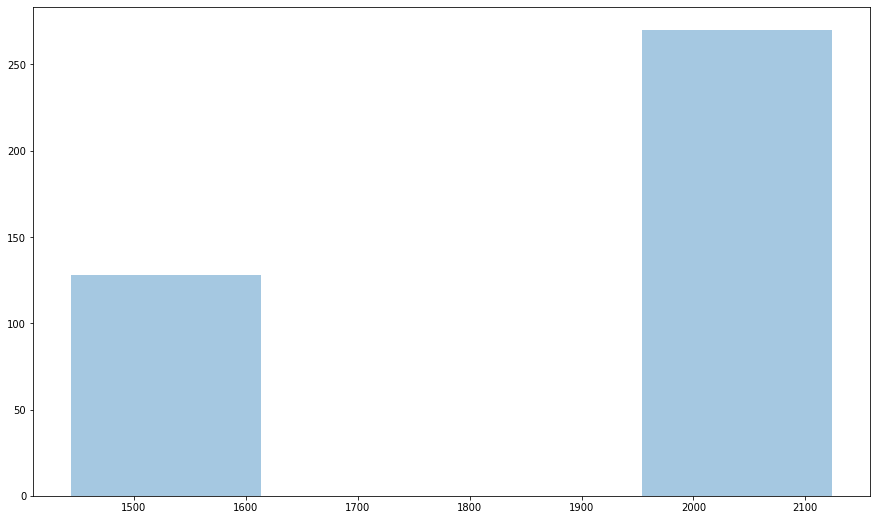

In [114]:
sns.distplot(a=h_list, kde=False)

In [115]:
print(w_list[:20])

[2056, 2056, 2056, 2056, 2056, 2056, 2056, 1444, 2056, 2056, 2056, 2056, 2056, 2056, 2056, 2056, 2056, 1444, 2056, 2056]


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


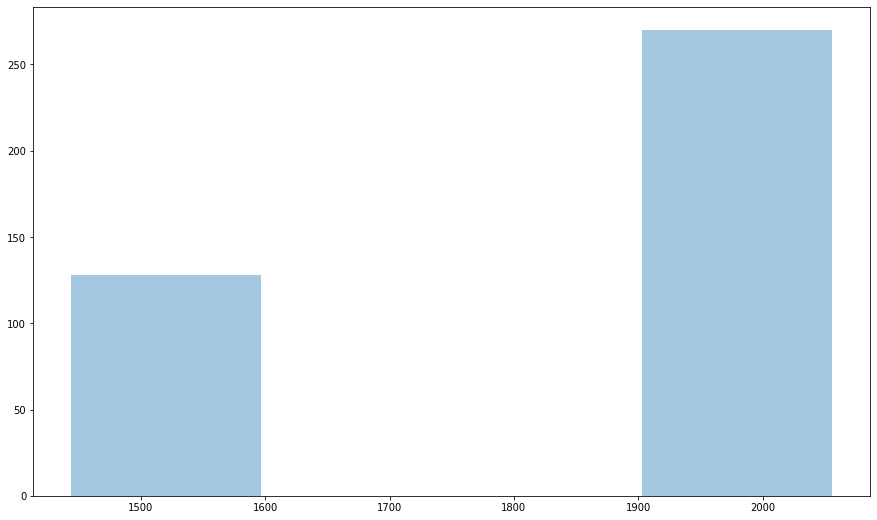

In [116]:
sns.distplot(a=w_list, kde=False)

In step 5, we get lists of image heights and widths. This will be used to plot the distributions
of heights and widths in step 6. The plots of distributions reveal that the majority of heights
and width are in the range of 1900 to 2100.

# Data Transformation for Object Detection

Data augmentation and transformation is a critical step in training deep learning
algorithms, especially for small datasets. The iChallenge-AMD dataset in this chapter has
only 400 images, which is considered a small dataset. As a reminder, we will later split 20
percent of this dataset for evaluation purposes. Since the images have different sizes, we
need to resize all images to a pre-determined size. Then, we can utilize a variety of
augmentation techniques, such as horizontal flipping, vertical flipping, and translation, to
expand our dataset during training.

In object detection tasks, when we perform such transformations on images, we also need
to update the labels. For instance, when we flip an image horizontally, the location of
objects in the image will change. While torchvision.transforms provides utility
functions for image transformations, we need to build our own functions for updating the
labels. In this recipe, we will develop a pipeline for transforming images and labels in
single-object detection. We will develop horizontal flipping, vertical flipping, translation,
and resizing. You can then add more transformations to the pipeline as you need.

1. First, we will define a helper function to resize images:

In step 1, we defined a helper function to resize PIL images and update the labels to a target
size. For resizing PIL images, we can use the resize function
from torchvision.transforms.functional. As a reminder, PIL returns the image size
in this format: width, height= image.size. This could be confusing and is sometimes a
source of bugs if you worked with the OpenCV packag

In [117]:
import torchvision.transforms.functional as TF

def resize_img_label(image,label=(0.,0.),target_size=(256,256)):
    w_orig,h_orig = image.size   
    w_target,h_target = target_size
    cx, cy= label
    
    # resize image and label
    image_new = TF.resize(image,target_size)
    label_new= cx/w_orig*w_target, cy/h_orig*h_target
    
    return image_new,label_new

(2124, 2056) (1182.26427759023, 1022.01884158854)
(256, 256) (142.4951295024006, 127.25526432230848)


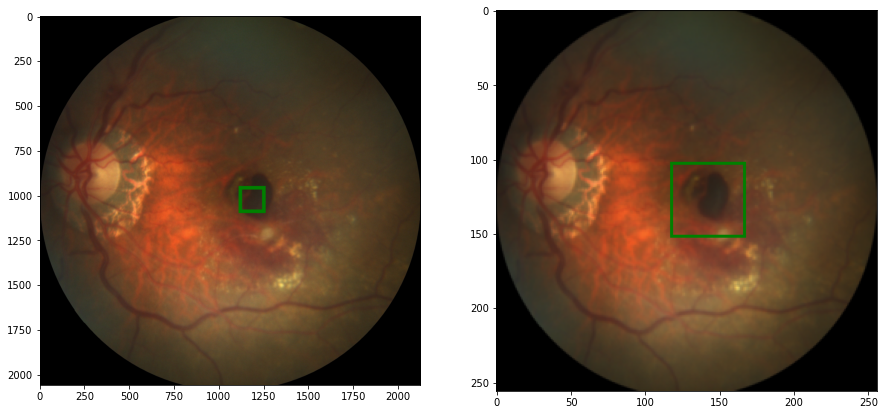

In [118]:
# load image
img, label=load_img_label(labels_df,1)   
print(img.size,label)

img_r,label_r=resize_img_label(img,label)
print(img_r.size,label_r)

plt.subplot(1,2,1)
show_img_label(img,label,w_h=(150,150),thickness=20)
plt.subplot(1,2,2)
show_img_label(img_r,label_r)

2. Next, we will define a helper function to randomly flip images horizontally:

In step 2, we built a helper function to horizontally flip images and labels. We used
the hflip function from torchvision to horizontally flip images. In the case of a
horizontal flip, the y coordinate remains the same and only the x coordinate of the fovea
location will change to width - x. Check out the image before and after flipping and
notice how the eye disk is moved from the left side to the right side of the image.

In [119]:
def random_hflip(image,label):
    w,h=image.size
    x,y=label        

    image = TF.hflip(image)
    label = w-x, y
    return image,label

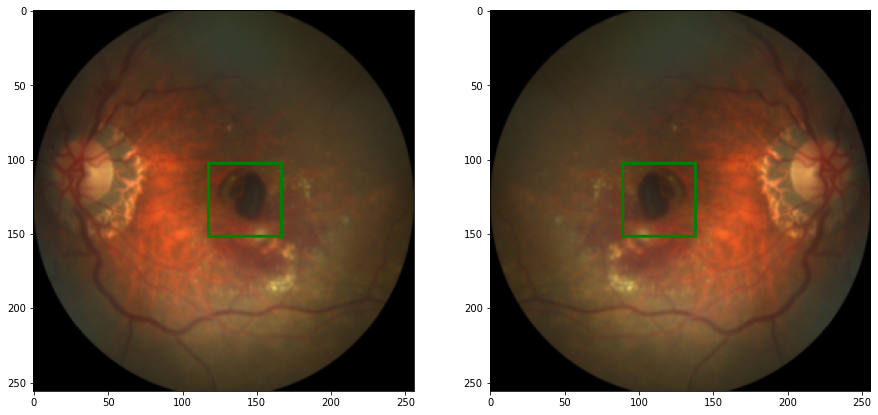

In [120]:
# load image and label
img, label=load_img_label(labels_df,1)   

# resize image and label
img_r,label_r=resize_img_label(img,label)

# horizantal flip
img_fh,label_fh=random_hflip(img_r,label_r)

plt.subplot(1,2,1)
show_img_label(img_r,label_r)
plt.subplot(1,2,2)
show_img_label(img_fh,label_fh)

3. Next, we will define a function to randomly flip images vertically:

In step 3, we built a helper function to vertically flip images and labels. We used the vflip
function from torchvision to vertically flip images. In the case of vertical flipping, the x
coordinate remains the same and only the y coordinate of the fovea location will change to
height - y. Check out the image before and after flipping and notice how the location of
the fovea and eye disk are changed.

In [121]:

def random_vflip(image,label):
    w,h=image.size
    x,y=label

    image = TF.vflip(image)
    label = x, w-y
    return image, label

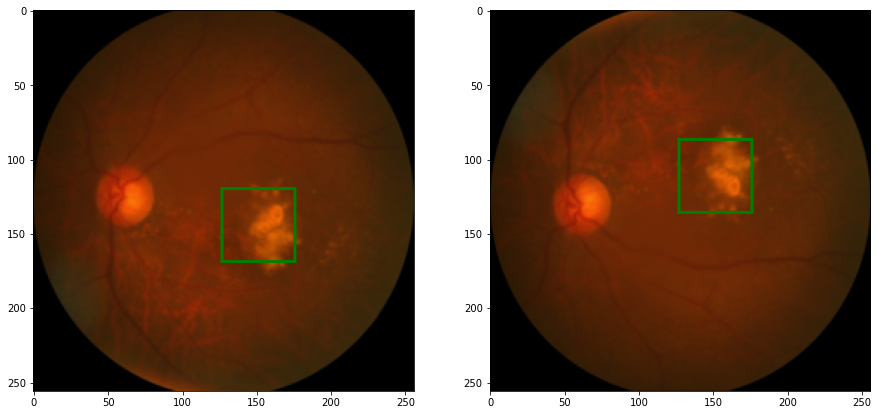

In [122]:
# load image and label
img, label=load_img_label(labels_df,7)   

# resize image and label
img_r,label_r=resize_img_label(img,label)

# vertical flip
img_fv,label_fv=random_vflip(img_r,label_r)

plt.subplot(1,2,1)
show_img_label(img_r,label_r)
plt.subplot(1,2,2)
show_img_label(img_fv,label_fv)

4. Next, we will define a helper function to randomly shift or translate images in
either direction:

In step 4, we defined a function to shift or translate images to the left, right, up, or down.
The amount of translation is chosen randomly; however, it is bounded by
the max_translate = (0.2, 0.2) parameter. This means that the maximum translation
in x and y dimensions will be 0.2*width and 0.2*height. For example, for an image size
of 256*256, the maximum translation will be 51 pixels in each direction. To set the
maximum image translation during data augmentation, consider the location of the object
of interest. You do not want the object to fall outside the image after translation. For most
problems, a value in the range of [0.1, 0.2] is safe. However, make sure to adjust this
value according to your specific problem. Also, to randomly translate the image in either
direction (left, right, up, or down), we generate a random value in the range of [-1, 1]
and multiply it by the maximum translation.

To translate images, we use the affine function from torchvision. This function can
perform other types of transformations, such as rotation, shearing, and scaling. Here, we
only used the translation feature. Lastly, both x and y coordinates of the fovea center could
change by the amount of translation.

In [123]:
import numpy as np
np.random.seed(1)

def random_shift(image,label,max_translate=(0.2,0.2)):
    w,h=image.size
    max_t_w, max_t_h=max_translate
    cx, cy=label

    # translate coeficinet, random [-1,1]
    trans_coef=np.random.rand()*2-1
    w_t = int(trans_coef*max_t_w*w)
    h_t = int(trans_coef*max_t_h*h)

    image=TF.affine(image,translate=(w_t, h_t),shear=0,angle=0,scale=1)
    label = cx+w_t, cy+h_t
        
    return image,label

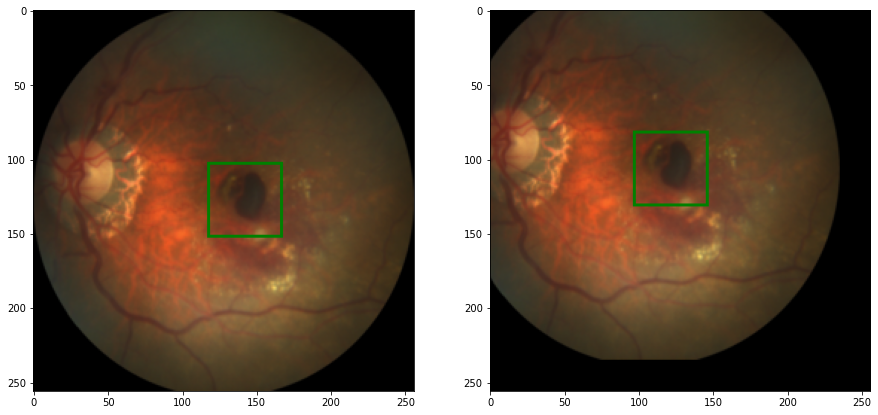

In [124]:
# load image and label
img, label=load_img_label(labels_df,1)   

# resize image and label
img_r,label_r=resize_img_label(img,label)

# horizantal flip
img_t,label_t=random_shift(img_r,label_r,max_translate=(.5,.5))

plt.subplot(1,2,1)
show_img_label(img_r,label_r)
plt.subplot(1,2,2)
show_img_label(img_t,label_t)

5. Next, we will compose multiple transformations into one function to define
transformer:

In step 5, we stacked multiple transformations into one function. We will later pass the
transformation function to the dataset class. As has been observed from the transformed
images, five transformations are sequentially applied to the PIL image. You should pay
attention to the order of the functions when building custom transformations. For instance,
it is better to resize the image first to reduce the computational complexity of other
transformations. Moreover, converting to tensors using TF.to_tensor goes at the end.
This transformation scales PIL images to the range of [0, 1] and reshapes images into the
[channel, height, width] shape. As a result, to display the transformed image, we use
TF.to_pil_image() to convert it back to a PIL image. We also parameterized the
augmentation parameters so that you can play with different values. If you want to disable
a transformation, you can simply set the probability to zero, as we will do for the validation
dataset. A common value for the probability of transformation is 0.5. Here, to force all
transformations, we set the probabilities to 1.0.

In [125]:
def transformer(image, label, params):
    image,label=resize_img_label(image,label,params["target_size"])
    
    if random.random() < params["p_hflip"]:
        image,label=random_hflip(image,label)
        
    if random.random() < params["p_vflip"]:            
        image,label=random_vflip(image,label)
        
    if random.random() < params["p_shift"]:                            
        image,label=random_shift(image,label, params["max_translate"])
        
    image=TF.to_tensor(image)
    return image, label

In [126]:
import random
np.random.seed(0)
random.seed(0)

# load image and label
img, label=load_img_label(labels_df,1)   

params={
    "target_size" : (256, 256),
    "p_hflip" : 1.0,
    "p_vflip" : 1.0,
    "p_shift" : 1.0,
    "max_translate": (0.2, 0.2),
}
img_t,label_t=transformer(img,label,params)

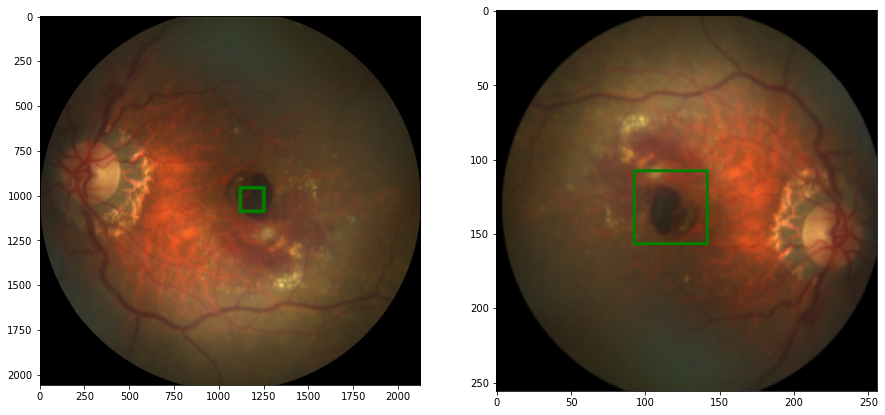

In [127]:
plt.subplot(1,2,1)
show_img_label(img,label,w_h=(150,150),thickness=20)
plt.subplot(1,2,2)
show_img_label(TF.to_pil_image(img_t),label_t)

## There is More

There are other types of transformations that you can apply to images for data
augmentation. Some of them do not require any update to the label.
For example, we can create new images by adjusting the brightness, as shown in the
following code block:

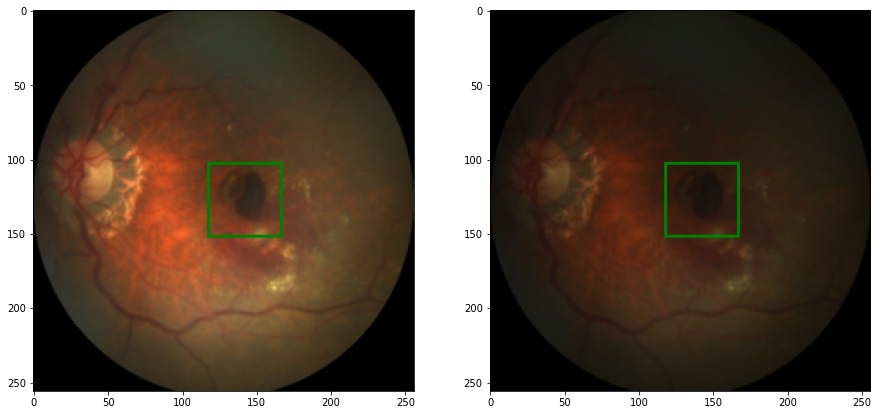

In [128]:
# load image and label
img, label=load_img_label(labels_df,1)   

# resize image and label
img_r,label_r=resize_img_label(img,label)

# adjust brightness
img_t=TF.adjust_brightness(img_r,brightness_factor=0.5)
label_t=label_r

plt.subplot(1,2,1)
show_img_label(img_r,label_r)
plt.subplot(1,2,2)
show_img_label(img_t,label_t)

Similarly, we can create new images by adjusting the contrast and gamma correction, as
shown in the following code block:

In [129]:
# brightness
img_t=TF.adjust_contrast(img_r,contrast_factor=0.4)

# gamma correction
img_t=TF.adjust_gamma(img_r,gamma=1.4)

There is another transformation that we usually perform on the labels. In this
transformation, we scale the labels to the range of [0, 1] using the following function:

For objection detection tasks, it is important to scale the labels to the range
of [0, 1] for better model convergence.

In [130]:
def scale_label(a,b):
    div = [ai/bi for ai,bi in zip(a,b)]
    return div

In [131]:
def transformer(image, label, params):
    image,label=resize_img_label(image,label,params["target_size"])

    if random.random() < params["p_hflip"]:
        image,label=random_hflip(image,label)
        
    if random.random() < params["p_vflip"]:            
        image,label=random_vflip(image,label)
        
    if random.random() < params["p_shift"]:                            
        image,label=random_shift(image,label, params["max_translate"])

    if random.random() < params["p_brightness"]:
        brightness_factor=1+(np.random.rand()*2-1)*params["brightness_factor"]
        image=TF.adjust_brightness(image,brightness_factor)

    if random.random() < params["p_contrast"]:
        contrast_factor=1+(np.random.rand()*2-1)*params["contrast_factor"]
        image=TF.adjust_contrast(image,contrast_factor)

    if random.random() < params["p_gamma"]:
        gamma=1+(np.random.rand()*2-1)*params["gamma"]
        image=TF.adjust_gamma(image,gamma)

    if params["scale_label"]:
        label=scale_label(label,params["target_size"])
        
    image=TF.to_tensor(image)
    return image, label

In [132]:
np.random.seed(0)
random.seed(0)

# load image and label
img, label=load_img_label(labels_df,1)

In [133]:
params={
    "target_size" : (256, 256),
    "p_hflip" : 1.0,
    "p_vflip" : 1.0,
    "p_shift" : 1.0,
    "max_translate": (0.5, 0.5),
    "p_brightness": 1.0,
    "brightness_factor": 0.8,
    "p_contrast": 1.0,
    "contrast_factor": 0.8,
    "p_gamma": 1.0,
    "gamma": 0.4,
    "scale_label": False,
}
img_t,label_t=transformer(img,label,params)

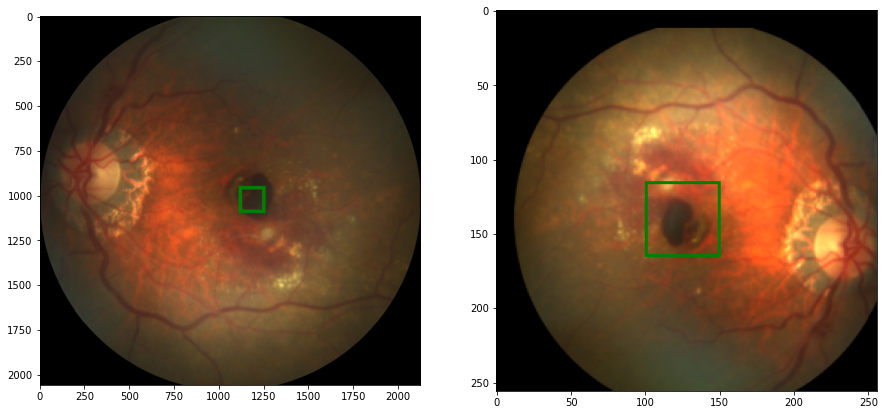

In [134]:
plt.subplot(1,2,1)
show_img_label(img,label,w_h=(150,150),thickness=20)
plt.subplot(1,2,2)
show_img_label(TF.to_pil_image(img_t),label_t)

In [135]:
def rescale_label(a,b):
    div = [ai*bi for ai,bi in zip(a,b)]
    return div

# Creating Custom Datasets

In this recipe, we will use the Dataset class from torch.utils.data to create custom
datasets for loading and processing data. We can do this by sub-classing the Dataset class
and overriding __init__ and the __getitem__ functions. The __len__ function returns
the dataset length and is callable with the Python len function. The __getitem__ function
returns an image at the specified index. Then, we will use the Dataloader class from
torch.utils.data to create data loaders. Using data loaders, we can automatically get
mini-batches of data for processing.

1. Let's define a custom dataset class. First, we will load the required packages:

In step 1, we defined the custom dataset class. For better code readability, we presented this
step in a few snippets. We first defined the bulk of the dataset class. Then, we implemented
the __init__ function. In this function, we loaded the fovea coordinates from
Fovea_location.xlsx into self.labels to be used as labels. To be able to load the
images from local files, we also get the full path to images in self.fullPath2img. As we
found out in the Exploratory data analysis recipe, 89 images are in the AMD folder and their
names start with the letter A, and the remainder are in the Non-AMD folder and their names
start with the letter N. Therefore, we used the first letter to find the image folder and
set prefix accordingly. Lastly, we set the transformer and transformation parameters.
Next, we defined the __getitem__ function. In this function, we load an image and its
label and then transform them using the transformer function. In the end, we overrode the
two class functions with __init__ and __getitem__.

In [136]:
from torch.utils.data import Dataset
from PIL import Image

In [137]:
class AMD_dataset(Dataset):
    def __init__(self, path2data, transform, trans_params):      
        pass    
      
    def __len__(self):
        # return size of dataset
        return len(self.labels)
      
    def __getitem__(self, idx):
        pass

In [185]:
# extract image name,index and labels from data:
def __init__(self, path2data, transform, trans_params):      

    # full path of the labels file
    path2labels=os.path.join(path2data,"Training400","Fovea_location.xlsx")

    # read and extract labels
    labels_df=pd.read_excel(path2labels,index_col="ID")
    #Filter image broken (DNN ADD NEW)
    labels_df=labels_df[~labels_df.imgName.isin(img_list)]
    labels_df=labels_df.reset_index(drop=True)
    self.labels = labels_df[["Fovea_X","Fovea_Y"]].values

    # extract ID and imgName columns
    self.imgName=labels_df["imgName"]
    self.ids=labels_df.index

    self.fullPath2img=[0]*len(self.ids)
    for id_ in self.ids:
        if self.imgName[id_][0]=="A":
            prefix="AMD"
        else:
            prefix="Non-AMD"
        self.fullPath2img[id_-1]=os.path.join(path2data,"Training400",prefix,self.imgName[id_])

    self.transform = transform
    self.trans_params=trans_params

In [186]:
# Get image value and transform
def __getitem__(self, idx):
    # load PIL image
    image = Image.open(self.fullPath2img[idx])  # open imagepath from __init__
    label= self.labels[idx]

    # transform to tensor
    image,label = self.transform(image,label,self.trans_params)

    return image, label

In [187]:
AMD_dataset.__init__=__init__
AMD_dataset.__getitem__=__getitem__

2. Next, we will create two objects of AMD_dataset:

In step 2, we created two objects of the AMD_dataset class. This is for data-splitting
purposes and will be cleared in the next step. We defined two transformation
parameters, trans_params_train and trans_params_val, and passed them to the two
instances, respectively. trans_params_train defined the transformations that we want to
apply to the training dataset. Thus, we enabled all of the data transformation functions
implemented in the Data transformation for object detection recipe with the probability of 0.5.
On the other hand, trans_params_val defined the transformations that we want to apply
to the validation dataset. Thus, we disabled all data augmentation functions by setting their
probabilities to 0.0. Only the resizing of images to 256*256 and the scaling of labels to the
range of [0, 1] were enabled for both the training and validation datasets.

In [188]:
trans_params_train={
    "target_size" : (256, 256),
    "p_hflip" : 0.5,
    "p_vflip" : 0.5,
    "p_shift" : 0.5,
    "max_translate": (0.2, 0.2),
    "p_brightness": 0.5,
    "brightness_factor": 0.2,
    "p_contrast": 0.5,
    "contrast_factor": 0.2,
    "p_gamma": 0.5,
    "gamma": 0.2,
    "scale_label": True,    
}


In [189]:
trans_params_val={
    "target_size" : (256, 256), # enabled
    "p_hflip" : 0.0,
    "p_vflip" : 0.0,
    "p_shift" : 0.0,
    "p_brightness": 0.0,
    "p_contrast": 0.0,
    "p_gamma": 0.0,
    "gamma": 0.0,
    "scale_label": True,   # enabled
}

In [190]:
path2data

'./data/'

In [191]:
amd_ds1=AMD_dataset(path2data,transformer,trans_params_train)
amd_ds2=AMD_dataset(path2data,transformer,trans_params_val)

In [206]:
amd_ds1.labels[:10] # position center of AMD

array([[1182.26427759, 1022.01884159],
       [ 967.75404587, 1016.94665548],
       [1220.20671391,  989.94403277],
       [1141.14088834, 1000.59495451],
       [1127.37183235, 1071.1094397 ],
       [1118.94143394, 1012.65881343],
       [1254.41912758, 1159.82315593],
       [ 701.29898526,  778.82674528],
       [1122.13037803, 1204.887661  ],
       [1121.73404337, 1132.44294394]])

In [192]:
print(len(amd_ds1))
print(len(amd_ds2))

398
398


3. Next, we will split the dataset into training and validation sets

In step 3, we created the training and validation datasets by splitting images into two
groups. To this end, we first split the image indices using ShuffleSplit from sklearn.
We assigned 20 percent of the images to the validation dataset. This resulted in 320 images
for training and 80 for evaluation. Then, we utilized the Subset class from torch.utils to
subset train_ds from the amd_ds1 dataset at the train_index indices. Similarly, we
subset val_ds from the amd_ds2 dataset at the val_index indices. Note that train_ds
inherits the transformer function of amd_ds1, while val_ds inherits the transformer
function of amd_ds2. By now, it should be clear to you why we defined two instances of
the AMD_dataset class in the first place: to have different transformations for the training
and validation datasets. If you only define one object of the dataset class and pass different
indices, they will have the same transformation function.

In [193]:
from sklearn.model_selection import ShuffleSplit

sss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

indices=range(len(amd_ds1))

for train_index, val_index in sss.split(indices):
    print(len(train_index))
    print("-"*10)
    print(len(val_index))

318
----------
80


In [194]:
from torch.utils.data import Subset

train_ds=Subset(amd_ds1,train_index) # Contains AMD and non AMD
print(len(train_ds))

val_ds=Subset(amd_ds2,val_index) # Contains AMD and non AMD
print(len(val_ds))

318
80


4. Let's now show a sample image from train_ds and val_ds.

n step 4, we depicted a sample image from both train_ds and val_ds. We defined a
helper function to display a tensor image together with its label as a + marker. The tensor
was in the C*H*W, shape so we reshaped it to H*W*C. The label contains the rescaled x and y
coordinates. Thus, we rescaled it back to the image size. We first depicted a sample image
from train_ds. If you rerun this snippet, you should see a different version of the sample
image due to random transformations. Next, we showed a sample image from val_ds.
There is no random transformation for the validation dataset, so you should see the same
image if rerunning this snippet.

Always visualize a few sample images and labels from your training and
validation datasets and make sure that they

In [195]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# fix random seed
np.random.seed(0)

In [196]:
def show(img,label=None):
    npimg = img.numpy().transpose((1,2,0))
    plt.imshow(npimg)
    if label is not None:
        label=rescale_label(label,img.shape[1:])        
        x,y=label
        plt.plot(x,y,'b+',markersize=20) 

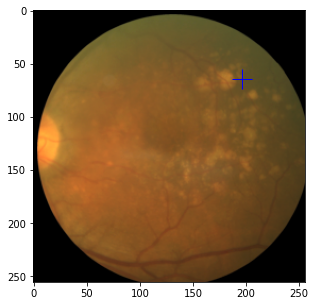

In [197]:
plt.figure(figsize=(5,5))
for img,label in train_ds:
    show(img,label)
    break

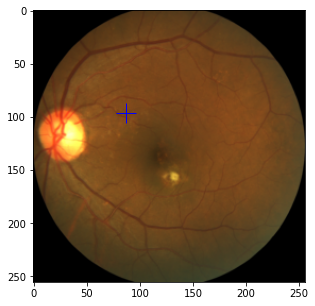

In [198]:
plt.figure(figsize=(5,5))
for img,label in val_ds:
    show(img,label)
    break

5. Next, we will define two data loaders for the training and validation datasets:

In step 5, we defined two data loaders for training and validation datasets. Data loaders
automate the fetching of mini-batches from the training and validation datasets during
training and evaluation. Creating PyTorch data loaders is simple. Simply pass the dataset
and define the batch size. The batch size for the training dataset is considered a
hyperparameter. So, you may want to try different values for optimum performance. For
the validation dataset, the batch size does not have any impact on the performance.

In [199]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)  

In [200]:
print(len(train_ds)) # 320 images
print(len(val_ds)) # 80 images
print(len(train_dl)) # 40 batch
print(len(val_dl)) # 5 batch

318
80
40
5


6. Let's get a batch of data from train_dl:

In step 6 and step 7, we got a batch of data from train_dl and val_dl. As has been
observed, the label batch is returned as a list. We needed a tensor of the torch.float32
type. Therefore, we converted the list to a tensor and changed its type as desired. Notice
that we get a batch of 8 samples from train_dl and a batch of 16 samples from val_dl
based on the pre-set batch size.

In [201]:
for img_b, label_b in train_dl:
    print(img_b.shape,img_b.dtype)
    print(label_b)
    break

torch.Size([8, 3, 256, 256]) torch.float32
[tensor([0.6449, 0.3651, 0.6880, 0.4935, 0.4517, 0.4801, 0.9452, 0.3633],
       dtype=torch.float64), tensor([0.3652, 0.6322, 0.6444, 0.4809, 0.8734, 0.5578, 0.4120, 0.4021],
       dtype=torch.float64)]


7. Similarly, we will get a batch from val_dl:

In [202]:
import torch

# extract a batch from trainin data
for img_b, label_b in train_dl:
    print(img_b.shape,img_b.dtype)

    # convert list to tensor
    label_b=torch.stack(label_b,1)
    label_b=label_b.type(torch.float32)
    print(label_b.shape,label_b.dtype)
    break

torch.Size([8, 3, 256, 256]) torch.float32
torch.Size([8, 2]) torch.float32


In [203]:
for img_b, label_b in val_dl:
    print(img_b.shape,img_b.dtype)

    # convert to tensor
    label_b=torch.stack(label_b,1)
    label_b=label_b.type(torch.float32)
    print(label_b.shape,label_b.dtype)
    break

torch.Size([16, 3, 256, 256]) torch.float32
torch.Size([16, 2]) torch.float32


# Creating the Model

In this recipe, we will build a model for our single-object detection problem. In our
problem, we are interested in predicting the fovea center as x and y coordinates in an eye
image. We will build a model consisting of several convolutional and pooling layers for this
task, as shown in the following diagram:

The model will receive a resized RGB image and provide two linear outputs corresponding
to the fovea coordinates. If you are interested in predicting the width or height of a
bounding box for other problems, you can simply increase the number of outputs to four.
In our model, we will utilize the skip connection technique introduced in the so-called
ResNet paper. You can access the paper, Deep Residual Learning for Image Recognition,
from https:/​/​arxiv.​org/​abs/​1512.​03385.

1. Let's implement the model class. First, we will load the packages:

In step 1, we defined the Net class that outlines the model. We presented the code as a few
snippets for clarity. First, we loaded the required packages. Then, we defined the class with
two main functions: __init__ and forward. Next, we defined the building blocks of the
model inside the __init__ function. It has five nn.Conv2d blocks. Notice that we
set padding=1 in all nn.Conv2d blocks to zero-pad both sides of the input, and keep the
output size divisible by two. This is important when building networks with skip
connections.

In [207]:
import torch.nn as nn
import torch.nn.functional as F

In [208]:
class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
    
    def forward(self, x):
        return x

In [209]:
def __init__(self, params):
    super(Net, self).__init__()

    C_in,H_in,W_in=params["input_shape"]
    init_f=params["initial_filters"] 
    num_outputs=params["num_outputs"] 
    '''
    Also, check out the number of input channels for each nn.Conv2d layer. The number of
    input channels, in the case of skip connections, will be the sum of the output channels from
    the previous layer and the skip lay
    '''
    self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3,stride=2,padding=1)
    self.conv2 = nn.Conv2d(init_f+C_in, 2*init_f, kernel_size=3,stride=1,padding=1)
    self.conv3 = nn.Conv2d(3*init_f+C_in, 4*init_f, kernel_size=3,padding=1)
    self.conv4 = nn.Conv2d(7*init_f+C_in, 8*init_f, kernel_size=3,padding=1)
    self.conv5 = nn.Conv2d(15*init_f+C_in, 16*init_f, kernel_size=3,padding=1)
    self.fc1 = nn.Linear(16*init_f, num_outputs)

In [210]:
def forward(self, x):
    '''
    Next, we defined the forward function that outlines the connections between the layers.
    Check out the way skip connections are built. We used avg_pool2d to get identity,
    which has the same size of x after passing through nn.Conv2d and F.max_pool2d. We
    used torch.cat to concatenate x with the identity in dim=1.
    '''
    identity=F.avg_pool2d(x,4,4)
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)

    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)

    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)
    
    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv4(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)

    x = F.relu(self.conv5(x))

    x=F.adaptive_avg_pool2d(x,1)
    x = x.reshape(x.size(0), -1)

    x = self.fc1(x)
    return x    
    '''
    There are four skip-connection blocks in the forward function. The last convolutional
    neural network (CNN) block is a regular nn.Conv2d layer without a skip connection. The
    output of the last CNN layer is usually referred to as extracted features. Then, we
    employed an adaptive_avg_pool2d layer to perform adaptive average pooling on the
    extracted features to get an output size of 1*1.
    Then, we reshaped or flattened the features and passed them to the linear layer. Since we
    are predicting the coordinate values, no activation is required for the final layer. In the end,
    we overrode the __init__ and forward functions of the Net class.
    '''

In [211]:
Net.__init__=__init__
Net.forward=forward


2. Let's now define an object of the Net class:

In step 2, we defined the model parameters and created an object of the Net class. We
decided to downsize images to 256*256. You can try different values, such
as 128*128 or 512*512. Also, initial_filters, the number of filters in the first CNN
layer, was set to 16. You can try 8 or other values. The number of outputs was set to 2 since
we only predict two coordinates. You can reuse this model for another single-object
detection problem with four outputs to predict the width and height of objects, too.
Next, we moved the model to the CUDA device. Finally, we printed the model. Note that
print (model) does not show functional layers created using torch.nn.functional.

In [213]:
params_model={
        "input_shape": (3,256,256),
        "initial_filters": 16, 
        "num_outputs": 2,
            }

model = Net(params_model)

In [214]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    model=model.to(device) 

In [215]:
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(19, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(51, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(115, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(243, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=256, out_features=2, bias=True)
)


Also, check out the number of input channels for each nn.Conv2d layer. The number of
input channels, in the case of skip connections, will be the sum of the output channels from
the previous layer and the skip layer.

# Defining Loss, Optimizer and IOU Metric

In [ ]:
loss_func = nn.SmoothL1Loss(reduction="sum")    

In [ ]:
n,c=8,2
y = 0.5 * torch.ones(n, c, requires_grad=True)
print(y.shape)

target = torch.zeros(n, c, requires_grad=False)
print(target.shape)

loss = loss_func(y, target)
print(loss.item())

y = 2 * torch.ones(n, c, requires_grad=True)
target = torch.zeros(n, c, requires_grad=False)
loss = loss_func(y, target)
print(loss.item())

In [ ]:
from torch import optim
opt = optim.Adam(model.parameters(), lr=3e-4)

In [ ]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr=get_lr(opt)
print('current lr={}'.format(current_lr))

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

In [ ]:
for i in range(100):
    lr_scheduler.step(1)

In [ ]:
def cxcy2bbox(cxcy,w=50./256,h=50./256):
    # define two new tensors for w and h
    w_tensor=torch.ones(cxcy.shape[0],1,device=cxcy.device)*w
    h_tensor=torch.ones(cxcy.shape[0],1,device=cxcy.device)*h

    # extract cx and cy
    cx=cxcy[:,0].unsqueeze(1)
    cy=cxcy[:,1].unsqueeze(1)
    
    # concat cx,cy,w and h
    boxes=torch.cat((cx,cy, w_tensor, h_tensor), -1) # cx,cy,w,h
    
    return torch.cat((boxes[:, :2] - boxes[:, 2:]/2, # xmin, ymin
                     boxes[:, :2] + boxes[:, 2:]/2), 1) # xmax, ymax

In [ ]:
torch.manual_seed(0)

cxcy=torch.rand(1,2)
print("center:", cxcy*256)

bb=cxcy2bbox(cxcy)
print("bounding box", bb*256)

In [ ]:
import torchvision
def metrics_batch(output, target):
    output=cxcy2bbox(output)
    target=cxcy2bbox(target)
    
    iou=torchvision.ops.box_iou(output, target)
    return torch.diagonal(iou, 0).sum().item()

In [ ]:
n,c=8,2
target = torch.rand(n, c, device=device)
target=cxcy2bbox(target)
metrics_batch(target,target)

In [ ]:
def loss_batch(loss_func, output, target, opt=None):   
    # get loss 
    loss = loss_func(output, target)
    
    # get performance metric
    metric_b = metrics_batch(output,target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

In [ ]:
for xb,label_b in train_dl:
    # convert to tensor
    label_b=torch.stack(label_b,1)
    label_b=label_b.type(torch.float32)
    label_b=label_b.to(device)
 
    l,m=loss_batch(loss_func,label_b,label_b)
    print(l,m)
    break

# Training and Evaluation of the Model

In [ ]:
def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        # convert to tensor
        yb=torch.stack(yb,1)
        yb=yb.type(torch.float32).to(device)
        
        # get model output
        output=model(xb.to(device))
        
        # get loss per batch
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt)
        
        # update running loss
        running_loss+=loss_b
        
        # update running metric
        if metric_b is not None:
            running_metric+=metric_b

    # average loss value
    loss=running_loss/float(len_data)
    
    # average metric value
    metric=running_metric/float(len_data)
    
    return loss, metric
            

In [ ]:
import copy
def train_val(model, params):
    # extract parameters
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    # history of loss values in each epoch
    loss_history={
        "train": [],
        "val": [],
    }
    
    # histroy of metric values in each epoch
    metric_history={
        "train": [],
        "val": [],
    }    
    
    
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # initialize best loss to a large value
    best_loss=float('inf')    
    
    for epoch in range(num_epochs):
        # get current learning rate
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))   

        # train the model
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)

        # collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        # evaluate the model
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
       
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)   
        
        
        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
            
        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 
            

        print("train loss: %.6f, accuracy: %.2f" %(train_loss,100*train_metric))
        print("val loss: %.6f, accuracy: %.2f" %(val_loss,100*val_metric))
        print("-"*10) 
        

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history        

In [ ]:
loss_func=nn.SmoothL1Loss(reduction="sum")
opt = optim.Adam(model.parameters(), lr=1e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

path2models= "./models/"
if not os.path.exists(path2models):
        os.mkdir(path2models)

params_train={
    "num_epochs": 1,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2models+"weights_smoothl1.pt",
}

# train and validate the model
model,loss_hist,metric_hist=train_val(model,params_train)

In [ ]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [ ]:
# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()